# Modeling task

This notebook covers the tasks given in ../task/Insilico PMS Task.pdf

I will go through every part step by step.

# Data Preprocessing

## Data analysis
 - Load and inspect the provided data.
 - Analyze and visualize the dataset to understand its characteristics
## Data splitting
 - Split the data into training and validation and/or test sets. Justify your split.


Here we need to load the data and check the characteristics, missing values and dynamics, e.g. the distance between the samples.

In [ ]:
# Import modules
import diffrax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
import pandas as pd
import seaborn as sns
# Setting jax to 64 bit for better precision
from jax import config

config.update("jax_enable_x64", True)

from numpyro.infer import MCMC, NUTS, init_to_median, init_to_sample, Predictive
from seaborn import color_palette

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, root_mean_squared_error

import arviz as az
import dill


In [2]:
# Load the Excel file
file_path = '../data/Insilico PMS Task - Bioprocess Data.xlsx'
data = pd.ExcelFile(file_path)

# Load data from each sheet into dataframes
df_concentrations = pd.read_excel(file_path, sheet_name='Sheet1')
df_feeding = pd.read_excel(file_path, sheet_name='Sheet2')
df_feed_media = pd.read_excel(file_path, sheet_name='Sheet3')
df_start_volumes = pd.read_excel(file_path, sheet_name='Sheet4')


In [3]:
# Print the head of each dataframe to inspect the initial rows
print("Concentration df")
print(df_concentrations.head())

print("Feeding df")
print(df_feeding.head())

print("Feed media df")
print(df_feed_media.head())

print("Start volumes df")
print(df_start_volumes.head())

Concentration df
  process_id  time         S         X    unit
0  process_1     0  0.951873  0.510666  mmol/L
1  process_1    12  0.741827  0.962049  mmol/L
2  process_1    24  0.414652  1.309773  mmol/L
3  process_1    36  0.235707  1.843965  mmol/L
4  process_1    48  0.103543  2.305891  mmol/L
Feeding df
  process_id  time feed_id  v_bolus unit
0  process_1    12   feed1     0.02    L
1  process_1    24   feed1     0.02    L
2  process_1    36   feed1     0.02    L
3  process_1    48   feed1     0.02    L
4  process_1    60   feed1     0.02    L
Feed media df
  feed_id   S    unit
0   feed1  15  mmol/L
1   feed2  20  mmol/L
Start volumes df
  process_id  time  v_reactor unit
0  process_1     0          1    L
1  process_2     0          1    L
2  process_3     0          1    L
3  process_4     0          1    L
4  process_5     0          1    L


In [4]:
# Overview of missing values in concentration_df and feeding_df
print(f"The dataset concentration_df has {np.sum(np.isnan(df_concentrations[['time', 'S', 'X']].values)) / np.size(df_concentrations[['time', 'S', 'X']].values):.0%} missing observations")
print(f"The dataset feeding_df has {np.sum(np.isnan(df_feeding[['time', 'v_bolus']].values)) / np.size(df_feeding[['time', 'v_bolus']].values):.0%} missing observations")

The dataset concentration_df has 6% missing observations
The dataset feeding_df has 0% missing observations


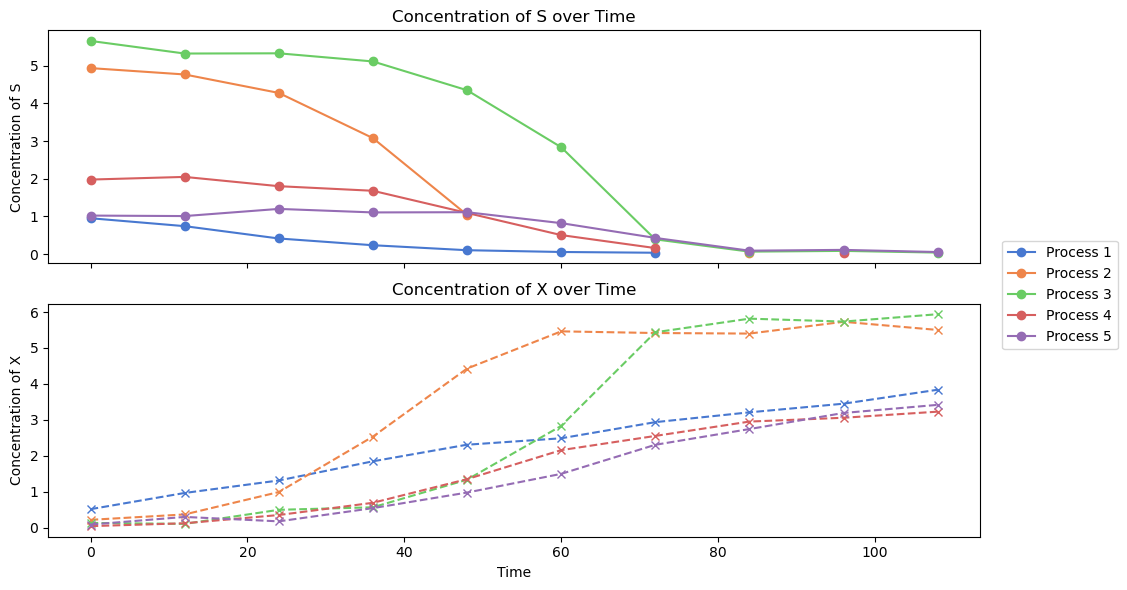

In [5]:
# Plot the data with different process IDs
colors = color_palette("muted").as_hex()

unique_process_ids = df_concentrations['process_id'].unique()

color_map = {process_id: colors[i % len(colors)] for i, process_id in enumerate(unique_process_ids)}

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot data for each process_id on each subplot
for process_id in unique_process_ids:
    subset = df_concentrations[df_concentrations['process_id'] == process_id]
    ax[0].plot(subset['time'], subset['S'], 'o-', label=f'{process_id} - S', color=color_map[process_id])
    ax[1].plot(subset['time'], subset['X'], 'x--', label=f'{process_id} - X', color=color_map[process_id])

# Set labels for the first subplot
ax[0].set_ylabel('Concentration of S')
ax[0].set_title('Concentration of S over Time')

# Set labels for the second subplot
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Concentration of X')
ax[1].set_title('Concentration of X over Time')

# Get handles and labels from one of the subplots
handles, labels = ax[0].get_legend_handles_labels()
# Adjust the labels based on your custom legend
custom_labels = [f'Process {i + 1}' for i in range(len(unique_process_ids))]

# Adjust legend location
fig.legend(handles, custom_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

# Show plot
plt.show()

### Handling missing data

Dealing with missing data is an important task in process modelling. Missing data can either be imputed or removed from the dataset. It can be seen from the plots that for some processes some missing data is at the end of the process, i.e. it needs to be extrapolated, which is a delicate task as we have no other point to interpolate between. However, we can also just mask the missing data and work with the normal data set. Otherwise, we could impute the data by spline or linear interpolation, for example.

To compare the dynamics of the dataset, we will perform a principal component analysis (PCA) to see the dynamics over time for each process. For PCA, we need to impute the data. In this oberservation-wise unfolded dataset, we can compare and cluster the datasets. By this, we can see which processes are more alike.

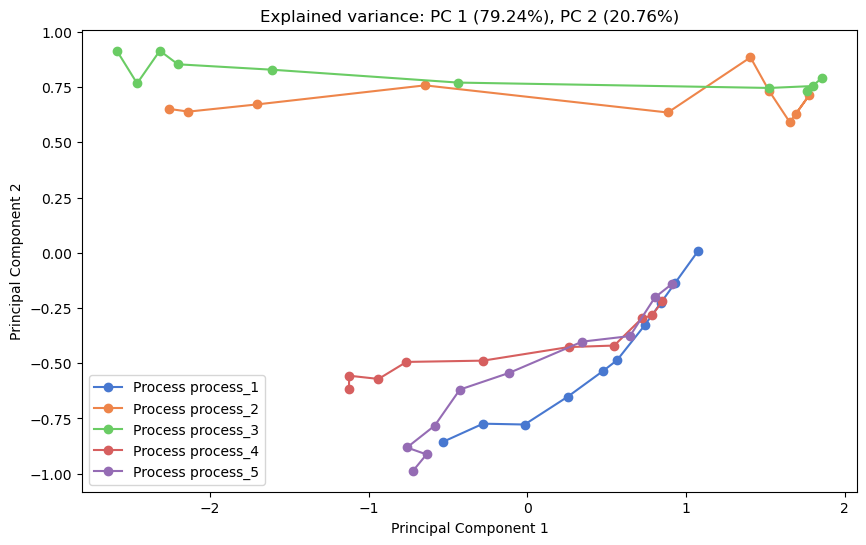

In [6]:
# Make a copy of the original dataframe and impute using linear interpolation
df_concentrations_imputed = df_concentrations.copy(deep=True)
df_concentrations_imputed["S"] = df_concentrations.groupby('process_id')['S'].transform(lambda x: x.interpolate(method='linear'))

# Combine S and X concentrations for PCA analysis
data_for_pca = df_concentrations_imputed[['S', 'X']]

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_pca)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

# Create a DataFrame for the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['process_id'] = df_concentrations_imputed['process_id']

# Plotting PCA results
colors = color_palette("muted").as_hex()
unique_process_ids = df_pca['process_id'].unique()
color_map = {process_id: colors[i % len(colors)] for i, process_id in enumerate(unique_process_ids)}

plt.figure(figsize=(10, 6))
for process_id in unique_process_ids:
    subset = df_pca[df_pca['process_id'] == process_id]
    plt.plot(subset['PC1'], subset['PC2'], "o-", label=f'Process {process_id}', color=color_map[process_id])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Concentration Data')
plt.legend()
plt.title(label=f"Explained variance: PC 1 ({(pca.explained_variance_ratio_[0] * 100):.2f}%), PC 2 ({(pca.explained_variance_ratio_[1] * 100):.2f}%)")

plt.show()

## Data splitting

A common approach for splitting a dataset for training and validation is to randomly split it into 80% training and 20% test data. Since the amount of datasets is quite small (n=5) and we want to make sure that we cover the whole design space for training, we will manually split the datasets into 4 training and 1 validation set by selecting a dataset which is in the middle of the design space. If we were to perform cross-validation (CV), we could use leave one out CV and validate our model across all datasets.

In [7]:
# Define process IDs for training and validation
train_process_ids = ['process_1', 'process_3', 'process_4', 'process_2']
validation_process_ids = ['process_5']

# Splitting 80/20 here. Not using random split to cover wide range and small dataset
# Split concentration data
train_data = df_concentrations[df_concentrations['process_id'].isin(train_process_ids)]
validation_data = df_concentrations[df_concentrations['process_id'].isin(validation_process_ids)]

# Store the training data in separate arrays

# Initialize lists to store data for all processes
all_times = []
all_S = []
all_S0 = []
all_X = []
all_X0 = []
all_feed_times = []
all_feed_volumes = []
all_start_volumes = []
all_feed_concentration_s = []

# Iterate over each process and collect the data
for process_id in train_process_ids:
    train_data = df_concentrations[df_concentrations['process_id'] == process_id]
    train_feeding = df_feeding[df_feeding['process_id'] == process_id]
    start_volume = df_start_volumes[df_start_volumes['process_id'] == process_id]['v_reactor'].values[0]
    feed_concentration_s = df_feed_media[df_feed_media['feed_id'] == 'feed1']['S'].values[0]

    times = train_data['time'].values
    S = train_data['S'].values
    S0 = S[0]
    X = train_data['X'].values
    X0 = X[0]
    feed_times = train_feeding['time'].values
    feed_volumes = train_feeding['v_bolus'].values

    # Append the data to the lists
    all_times.append(times)
    all_S.append(S)
    all_S0.append(S0)
    all_X.append(X)
    all_X0.append(X0)
    all_feed_times.append(feed_times)
    all_feed_volumes.append(feed_volumes)
    all_start_volumes.append(start_volume)
    all_feed_concentration_s.append(feed_concentration_s)

# Convert the lists to JAX compatible arrays
all_times = jnp.array(all_times, dtype=jnp.float64)
all_S = jnp.array(all_S, dtype=jnp.float64)
all_S0 = jnp.array([all_S0], dtype=jnp.float64).reshape(-1,1)
all_X = jnp.array(all_X, dtype=jnp.float64)
all_X0 = jnp.array([all_X0], dtype=jnp.float64).reshape(-1,1)
all_feed_times = jnp.array(all_feed_times, dtype=jnp.float64)
all_feed_volumes = jnp.array(all_feed_volumes, dtype=jnp.float64)
all_start_volumes = jnp.array([all_start_volumes], dtype=jnp.float64).reshape(-1,1)
all_feed_concentration_s = jnp.array([all_feed_concentration_s], dtype=jnp.float64).reshape(-1,1)


# Model Training, Validation and Analysis

## Process Model
 - Develop a mathematical model of the simplified bioprocess that describes the changes
of concentrations in time using the JAX ML framework. You may choose any appropriate
modeling and inference technique.
 - Ensure that the model accounts for the uncertainty in the data.
 - Explain and justify your probabilistic model and choice of training algorithm - what
alternatives did you consider?
 - Visualize and present the inferred kinetic function, the predicted concentrations and
the accuracy of the model, including any uncertainty of the predictions.


### Solution approach

The data presents us with some challenges: missing data, discrete, non-continuous feeding and unknown reaction kinetics that need to be accounted for in the model.

We aim to model an unknown reaction system with discrete bolus feeding after each sampling. Given that the only reaction is $1S$ -> $1X$, the most suitable approach is a hybrid model that explicitly incorporates mass balances while learning the dependence of concentrations on $S$.

A common strategy for such problems is to formulate an ODE system and enhance it with a data-driven component. One option is to fit a simple first-order kinetic model and use an artificial neural network (ANN) to capture plant-model mismatch. Alternatively, we can replace the reaction rate parameter $k$ with an ANN to learn the kinetic function directly. Given the reaction simplicity, the latter approach offers a flexible yet interpretable solution. It might be advisable to have two independent rate parameters $k_1$ and $k_2$, each represent by an ANN to consider independent kinetcs. However, from the equation $1S$ -> $1X$, in this case we rely on equimolar turnover.

To account for uncertainty (e.g., measurement noise), we model the system using JAX and NumPyro, a Bayesian probabilistic modeling framework. Since the dataset is small, we employ Markov Chain Monte Carlo (MCMC) with No-U-Turn Sampling (NUTS) to obtain more accurate posterior distributions. Compared to **Stochastic Variational Inference (SVI)**, which approximates posteriors using optimization, **MCMC provides more accurate uncertainty estimates** at the cost of higher computational expense. Given the limited amount of data in this problem, **the additional computational cost of MCMC is justified by its ability to capture true parameter uncertainty more reliably**. In summary: MCMC has the interesting property that it will asymptotically converge to the target distribution.

In summary:
- **NumPyro** enables probabilistic modeling and Bayesian inference in a scalable way using JAX
- **MCMC provides accurate posterior distributions**, essential for robust uncertainty quantification
- **NUTS (No-U-Turn Sampler) improves sampling efficiency** by automatically tuning step sizes and trajectories
- **This approach is well-suited for small datasets**, where accurate uncertainty estimates are critical


__Note:__ 
 - everything is coded from scatch in JAX to make it easier to understand and debug. However, it would also be possible (and probably a bit faster) to use available JAX NN frameworks like equinox or flax


In [ ]:
# Define dropout function for tuning task later
def custom_dropout(inputs: jnp.array, dropout_rate: float, rng_key: jax.random.PRNGKey, train: bool=False) -> jnp.array:
    """
    Custom dropout function to randomly drop units with a specified probability during training.

    Args:
        inputs (array): Input array to apply dropout.
        dropout_rate (float): Probability of dropping each unit.
        rng_key (jax.random.PRNGKey): Random key for dropout.
        train (bool): Whether or not the model is in training mode.

    Returns:
        array: Output array with dropout applied.
    """

    # Only do dropout during training and return unchanged inputs otherwise
    if dropout_rate == 0.0 or not train:
        return inputs
    
    # Generate random mask
    keep_prob = 1.0 - dropout_rate
    mask = jax.random.bernoulli(rng_key, keep_prob, inputs.shape)
    
    # Scale the inputs to maintain expected values
    return jnp.where(mask, inputs / keep_prob, 0.0)

# The raction model
def reaction_model(t: float, concentrations: jnp.array, args: tuple, train: bool=True) -> jnp.array:
    """
    Reaction model to describe the changes in concentrations over time using a neural network.

    Args:
        t (float): Time variable.
        concentrations (array): Current concentrations [S, X].
        args (tuple): Model parameters.
        train (bool): Whether or not the model is in training mode.

    Returns:
        array: Derivatives [dS_dt, dX_dt].
    """

    # Split the concentrations
    S, X = concentrations
    
    # Define variables. Can be extended for further arguments
    theta = args

    # Split theta into weights and biases
    w1, b1, w2, b2 = theta
    
    # Split random key to dropout key and random number generator
    # Note: improve this, by passing an extra PRNG to not reuse the same key again which reduces stoachsticity
    dropout_key, dropout_rng = jax.random.split(jax.random.PRNGKey(0))
    
    # Define dropout rate for the dropout layer during training
    dropout_rate = 0.5
    
    # Apply the ANN with custom dropout
    k_ANN = jax.nn.relu(jnp.dot(S, w1) + b1)
    dropout1_rng, dropout2_rng = jax.random.split(dropout_rng)
    k_ANN = custom_dropout(k_ANN, dropout_rate, dropout1_rng, train=False)

    k_ANN = jnp.dot(k_ANN, w2) + b2

    # Ensure k_ANN is scalar
    k_ANN = jnp.squeeze(k_ANN)

    # Define the actual ODEs
    dS_dt = -k_ANN * S
    dX_dt = k_ANN * S
    
    return jnp.array([dS_dt, dX_dt])

**Bolus Feeding**

Unlike continuous feeding, this system operates with discrete bolus feeding. Therefore, we must discretize the system at each feeding interval, updating the concentration of $S$ based on the composition of the added feed (feed1 or feed2). Additionally, we must account for the dilution effect on $X$ caused by the volume increase due to feeding.

In [9]:
# We need to consider the mass balances due to feeding. Therefore we update the states at every feeding event.
def update_states(concentrations: jnp.array, feed_volume: float, feed_concentration_s: float, current_volume: float) -> jnp.array:
    """
    Update the concentrations and volume due to feeding events.

    Args:
        concentrations (array): Current concentrations [S, X].
        feed_volume (float): Volume of the feeding event.
        feed_concentration_s (float): Concentration of S in the feed.
        current_volume (float): Current volume of the reactor.

    Returns:
        tuple: Updated concentrations [new_S, new_X], new volume.
    """
    
    # Split the concentrations into variables
    S, X = concentrations
    
    # Calculate fed amount of S
    feed_amount_S = feed_volume * feed_concentration_s
    
    # Calculate new volume after feeding event
    new_volume = current_volume + feed_volume
    
    # Update S concentration
    new_S = (S * current_volume + feed_amount_S) / new_volume
    
    # Update X concentration
    new_X = (X * current_volume) / new_volume
    
    return jnp.array([new_S, new_X]), new_volume

In [10]:
# To solve the ODE system and consider the mass balance we compile another function

# Solver function using diffrax
def solve_reaction_with_feeding(t: jnp.array, S0: float, X0: float, theta: tuple, feed_times: jnp.array, feed_volumes: jnp.array, feed_concentration_s: float, start_volume: float) -> jnp.array:
    """
    Solver function to compute concentrations over time considering feeding events.

    Args:
        t (array): Array of time points.
        S0 (float): Initial concentration of S.
        X0 (float): Initial concentration of X.
        theta (tuple): Model parameters.
        feed_times (array): Array of feeding times.
        feed_volumes (array): Array of feeding volumes.
        feed_concentration_s (float): Concentration of S in the feed.
        start_volume (float): Initial volume of the reactor.

    Returns:
        array: Array of concentrations over time.
    """
    
    # Remove extra dimension if there is any
    feed_concentration_s = feed_concentration_s.squeeze()
    start_volume = start_volume.squeeze()
    
    # Define initial concentrations
    initial_concentrations = jnp.array([S0.squeeze(), X0.squeeze()])
    
    # Define ODE solver. Heun is a fast solver for less stiff ODEs and speeds up computation
    solver = diffrax.Heun()
    
    # Define start and end time of the ODE interval
    t0 = t[0]
    t1 = t[-1]
    
    # saveat = diffrax.SaveAt(ts=t)  # Save the solution at the specified time points
    
    obs_sols = [initial_concentrations]
    reac_vol = start_volume

    # Loop through the feeding events and concatenate all the results. The new concentrations are only kept for the next interval of the feed.
    for i in range(len(feed_times)):
        t1 = feed_times[i]
        # Define the ODE solver
        sol = diffrax.diffeqsolve(
            diffrax.ODETerm(reaction_model),
            solver,
            t0=t0,
            t1=t1,
            dt0=0.1,
            y0=initial_concentrations,
            args=theta,
        )
        sol_ys = sol.ys.squeeze()
        obs_sols.append(sol_ys)
        
        # Feeding event
        initial_concentrations = sol_ys
        feed_volume = feed_volumes[i]
        initial_concentrations, reac_vol = update_states(initial_concentrations, feed_volume, feed_concentration_s, reac_vol)
        t0 = t1
    
    return jnp.vstack(obs_sols)

**Probabilistic model using NumPyro**

In real-world scenarios, measurements are often noisy due to experimental errors, sensor limitations, or inherent variability in biological and chemical systems. Traditional deterministic models struggle with such uncertainty, making probabilistic modeling a more effective approach.

However, Bayesian inference allows us to incorporate prior knowledge and update our beliefs based on observed data. Bayes’ theorem is given by:


$P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)}$

where:  
- $P(\theta | D)$ is the **posterior probability** (updated belief about parameters after observing data)
- $P(D | \theta)$ is the **likelihood** (probability of the data given the parameters)
- $P(\theta)$ is the **prior probability** (our belief about the parameters before seeing the data)
- $P(D)$ is the **evidence** (a normalization constant)

Using **NumPyro**, a probabilistic programming framework built on JAX, we can efficiently estimate the full posterior distribution rather than just point estimates. This provides uncertainty estimates for both model parameters and predictions.

It has several advantages:

 - Unlike traditional machine learning models, Bayesian methods do not just give a single prediction but a distribution over possible predictions, allowing us to capture confidence intervals
 - If we have prior domain knowledge (e.g., reaction rates must be positive), we can encode this information through prior distributions, making the model more robust
 - By modeling noise explicitly in the likelihood function, Bayesian methods account for measurement errors and propagate uncertainty through the model
 - Instead of just predicting a single concentration value, we obtain credible intervals, helping us assess the reliability of predictions and make informed decisions

In the following, we are replacing our rate parameter by an ANN and train the hyperparameters as uncertain variables. We consider the following priors in our model:

- Weights ($w_1$, $w_2$) are sampled from a HalfNormal prior ensuring positivity to allow faster convergence and considering that the final rate parameter should also be positive
- Bias terms ($b_1$, $b_2$) are modeled using Normal priors, which are reasonable given their potential to take negative or positive values
- The inital values $S_0$ and $X_0$ are sampled from TruncatedNormal distributions, knowing that they can not take negative values
- We mask missing values and exclude them from the inference
- The noise in our data is modeled through the sigma terms, considering the normally distributed noise


In [ ]:
# We need to build a model function to be used with numpyro. Here, we sample the hyperparameters from our ANN to make it probabilistic.
def model(t: jnp.array, S0: float=None, X0: float=None, S_obs: jnp.array=None, X_obs: jnp.array=None, feed_times:jnp.array=None, feed_volumes: jnp.array=None, feed_concentration_s: float=None,
          start_volume:float=None):
    """
    Probabilistic model using NumPyro to sample the hyperparameters for the ANN used in the reaction model.

    Args:
        t (array): Array of time points.
        S0 (float): Initial concentration of S.
        X0 (float): Initial concentration of X.
        S_obs (array): Observed concentrations of S.
        X_obs (array): Observed concentrations of X.
        feed_times (array): Array of feeding times.
        feed_volumes (array): Array of feeding volumes.
        feed_concentration_s (float): Concentration of S in the feed.
        start_volume (float): Initial volume of the reactor.

    Returns:
        None
    """
    
    n_x = 1 # Dimension of the inputs
    n_h = 4 # Dimension of hidden layer
    n_y = 1 # Dimension of output
    
    w1 = numpyro.sample("w1", dist.HalfNormal(jnp.ones((n_x, n_h))))
    w2 = numpyro.sample("w2", dist.HalfNormal(jnp.ones((n_h, n_y))))
    
    b1 = numpyro.sample("b1", dist.Normal(jnp.zeros(n_h), jnp.ones(n_h)))
    b2 = numpyro.sample("b2", dist.Normal(jnp.zeros(n_y), jnp.ones(n_y)))

    theta = (w1, b1, w2, b2)

    S0 = numpyro.sample('S0', dist.TruncatedNormal(S0.squeeze(), 0.1, low=0.0))
    X0 = numpyro.sample('X0', dist.TruncatedNormal(X0.squeeze(), 0.1, low=0.0))
    
    num_datasets = t.shape[0]
    
    sigma_S = numpyro.sample("sigma_S", dist.HalfNormal(0.1).expand((t.shape)))
    sigma_X = numpyro.sample("sigma_X", dist.HalfNormal(0.1).expand((t.shape)))
    
    concentrations_pred_all = []

    
    for i in range(num_datasets):
        concentrations_pred = solve_reaction_with_feeding(t[i], S0[i], X0[i], theta, feed_times[i], 
                                                      feed_volumes[i], feed_concentration_s[i], start_volume[i])
        concentrations_pred_all.append(concentrations_pred.T)
    concentrations_pred_all = jnp.array(concentrations_pred_all)


    
    if S_obs is not None:
        S_obs = S_obs.reshape(num_datasets, -1)
        mask_S = jnp.isfinite(S_obs)
        numpyro.sample('obs_S', dist.Normal(concentrations_pred_all[:, 0, :], sigma_S).mask(mask_S), obs=S_obs)
    else:
        numpyro.sample('obs_S', dist.Normal(concentrations_pred_all[:, 0, :], sigma_S))
    if X_obs is not None:
        X_obs = X_obs.reshape(num_datasets, -1)
        mask_X = jnp.isfinite(X_obs)
        numpyro.sample('obs_X', dist.Normal(concentrations_pred_all[:, 1, :], sigma_X).mask(mask_X), obs=X_obs)
    else:
        numpyro.sample('obs_X', dist.Normal(concentrations_pred_all[:, 1, :], sigma_X))
    


**Note on vmap**

Normally, we should vectorize our function within the model over the data sets with a common parameter array theta. We could accomplish this with the following code. For some reason, vmap throws an error internally, so we fall back to a for loop.

```
solve_reaction_with_feeding_vec = jax.vmap(solve_reaction_with_feeding, in_axes=(0, 0, 0, None, 0, 0, 0, 0))

concentrations_pred = solve_reaction_with_feeding_vec(t, S0, X0, theta, feed_times, feed_volumes, feed_concentration_s, start_volume)
```

**Running inference**
In the following section we are running an inference on our training data. First, we start with a warm up phase and sample then in the second phase. In particular, during warmup, we adapt the step size and mass matrix to achieve a certain target acceptance probability which is 0.8, by default. We use the sample from the end of the warmup phase to seed a MCMC chain from which we generate the desired number of samples from our target distribution. To achieve good convergence, the warmup phase and number of samples should be large, e.g. >1,000. To keep computational cost low, we limit this here to only 300. Usually good convergence is achieved when the effective sample_size $n_{eff}$ is large and the  gelman rubin diagnostic $\hat{R}$ is close to 1.0.

In [12]:
# Inference using MCMC
nuts_kernel = NUTS(model, dense_mass=True, init_strategy=init_to_median())
mcmc = MCMC(nuts_kernel, num_samples=300, num_warmup=300)

mcmc.run(jax.random.PRNGKey(0), all_times, all_S0, all_X0, all_S, all_X, all_feed_times, 
             all_feed_volumes, all_feed_concentration_s, all_start_volumes)

mcmc.print_summary()

sample: 100%|██████████| 600/600 [3:27:14<00:00, 20.72s/it, 1023 steps of size 1.41e-02. acc. prob=0.88]  



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       S0[0]      1.14      0.08      1.13      1.02      1.27    108.44      1.02
       S0[1]      5.73      0.09      5.68      5.63      5.86      7.23      1.18
       S0[2]      2.18      0.09      2.19      2.02      2.31     22.44      1.09
       S0[3]      5.24      0.08      5.24      5.09      5.36     38.95      1.04
       X0[0]      0.83      0.10      0.84      0.67      0.97     14.59      1.19
       X0[1]      0.12      0.06      0.12      0.02      0.20     39.13      1.02
       X0[2]      0.08      0.04      0.07      0.01      0.13     28.79      1.05
       X0[3]      0.33      0.08      0.33      0.20      0.44    106.56      1.00
       b1[0]     -1.43      0.60     -1.35     -2.38     -0.51     39.38      1.03
       b1[1]     -1.31      0.56     -1.29     -2.22     -0.43     76.55      1.04
       b1[2]     -1.32      0.63     -1.23     -2.32     -0.26     71.14      1.00
   

In [12]:
with open("./model_fit.pkl", "rb") as file:
    mcmc = dill.load(file)

**Posterior distribution**

Once we run MCMC inference using NumPyro, we obtain posterior samples of the model parameters. These samples represent the uncertainty in our estimates given the observed data and the prior distributions. Each key in posterior_samples corresponds to a sampled parameter (e.g., $w1$, $w2$, $S0$, etc.), and its value is an array containing multiple posterior samples collected during the inference process. We can use the arviz package to visualize the distributions of our posteriors.

In [13]:
posterior_samples = mcmc.get_samples()

In [14]:
# Iterate over each process and collect the data
all_times_test = []
all_S_test = []
all_S0_test = []
all_X_test = []
all_X0_test = []
all_feed_times_test = []
all_feed_volumes_test = []
all_start_volumes_test = []
all_feed_concentration_s_test = []

for process_id in validation_process_ids:
    test_data = df_concentrations[df_concentrations['process_id'] == process_id]
    test_feeding = df_feeding[df_feeding['process_id'] == process_id]
    start_volume_test = df_start_volumes[df_start_volumes['process_id'] == process_id]['v_reactor'].values[0]
    feed_concentration_s_test = df_feed_media[df_feed_media['feed_id'] == 'feed1']['S'].values[0]

    times_test = test_data['time'].values
    S_test = test_data['S'].values
    S0_test = S_test[0]
    X_test = test_data['X'].values
    X0_test = X_test[0]
    feed_times_test = test_feeding['time'].values
    feed_volumes_test = test_feeding['v_bolus'].values

    # Append the data to the lists
    all_times_test.append(times_test)
    all_S_test.append(S_test)
    all_S0_test.append(S0_test)
    all_X_test.append(X_test)
    all_X0_test.append(X0_test)
    all_feed_times_test.append(feed_times_test)
    all_feed_volumes_test.append(feed_volumes_test)
    all_start_volumes_test.append(start_volume_test)
    all_feed_concentration_s_test.append(feed_concentration_s_test)

# Convert the lists to JAX compatible arrays
all_times_test = jnp.array(all_times_test, dtype=jnp.float64)
all_S_test = jnp.array(all_S_test, dtype=jnp.float64)
all_S0_test = jnp.array([all_S0_test], dtype=jnp.float64).reshape(-1,1)
all_X_test = jnp.array(all_X_test, dtype=jnp.float64)
all_X0_test = jnp.array([all_X0_test], dtype=jnp.float64).reshape(-1,1)
all_feed_times_test = jnp.array(all_feed_times_test, dtype=jnp.float64)
all_feed_volumes_test = jnp.array(all_feed_volumes_test, dtype=jnp.float64)
all_start_volumes_test = jnp.array([all_start_volumes_test], dtype=jnp.float64).reshape(-1,1)
all_feed_concentration_s_test = jnp.array([all_feed_concentration_s_test], dtype=jnp.float64).reshape(-1,1)


In [16]:
posterior_predictive = Predictive(model, posterior_samples)(jax.random.PRNGKey(1), 
                                                            t=all_times_test,
                                                            S0=all_S0_test,
                                                            X0=all_X0_test,
                                                            S_obs=None,
                                                            X_obs=None,
                                                            feed_times=all_feed_times_test,
                                                            feed_volumes=all_feed_volumes_test,
                                                            feed_concentration_s=all_feed_concentration_s_test,
                                                            start_volume=all_start_volumes_test)

**Posterior plotting with arviz**

Here we can use arviz to plot the posterior distributions of our model. We can check how broad or bent our distributions are are use this knowledege, to e.g. remove parameters or adjust the prior distributions accordingly.

We can also plot the 90% highest density interval (HDI) to understand better the characterisics of our distribution.

/Users/niels/miniconda3/envs/modelling_task/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (101) in plot_posterior, generating only 40 plots
  warnings.warn(


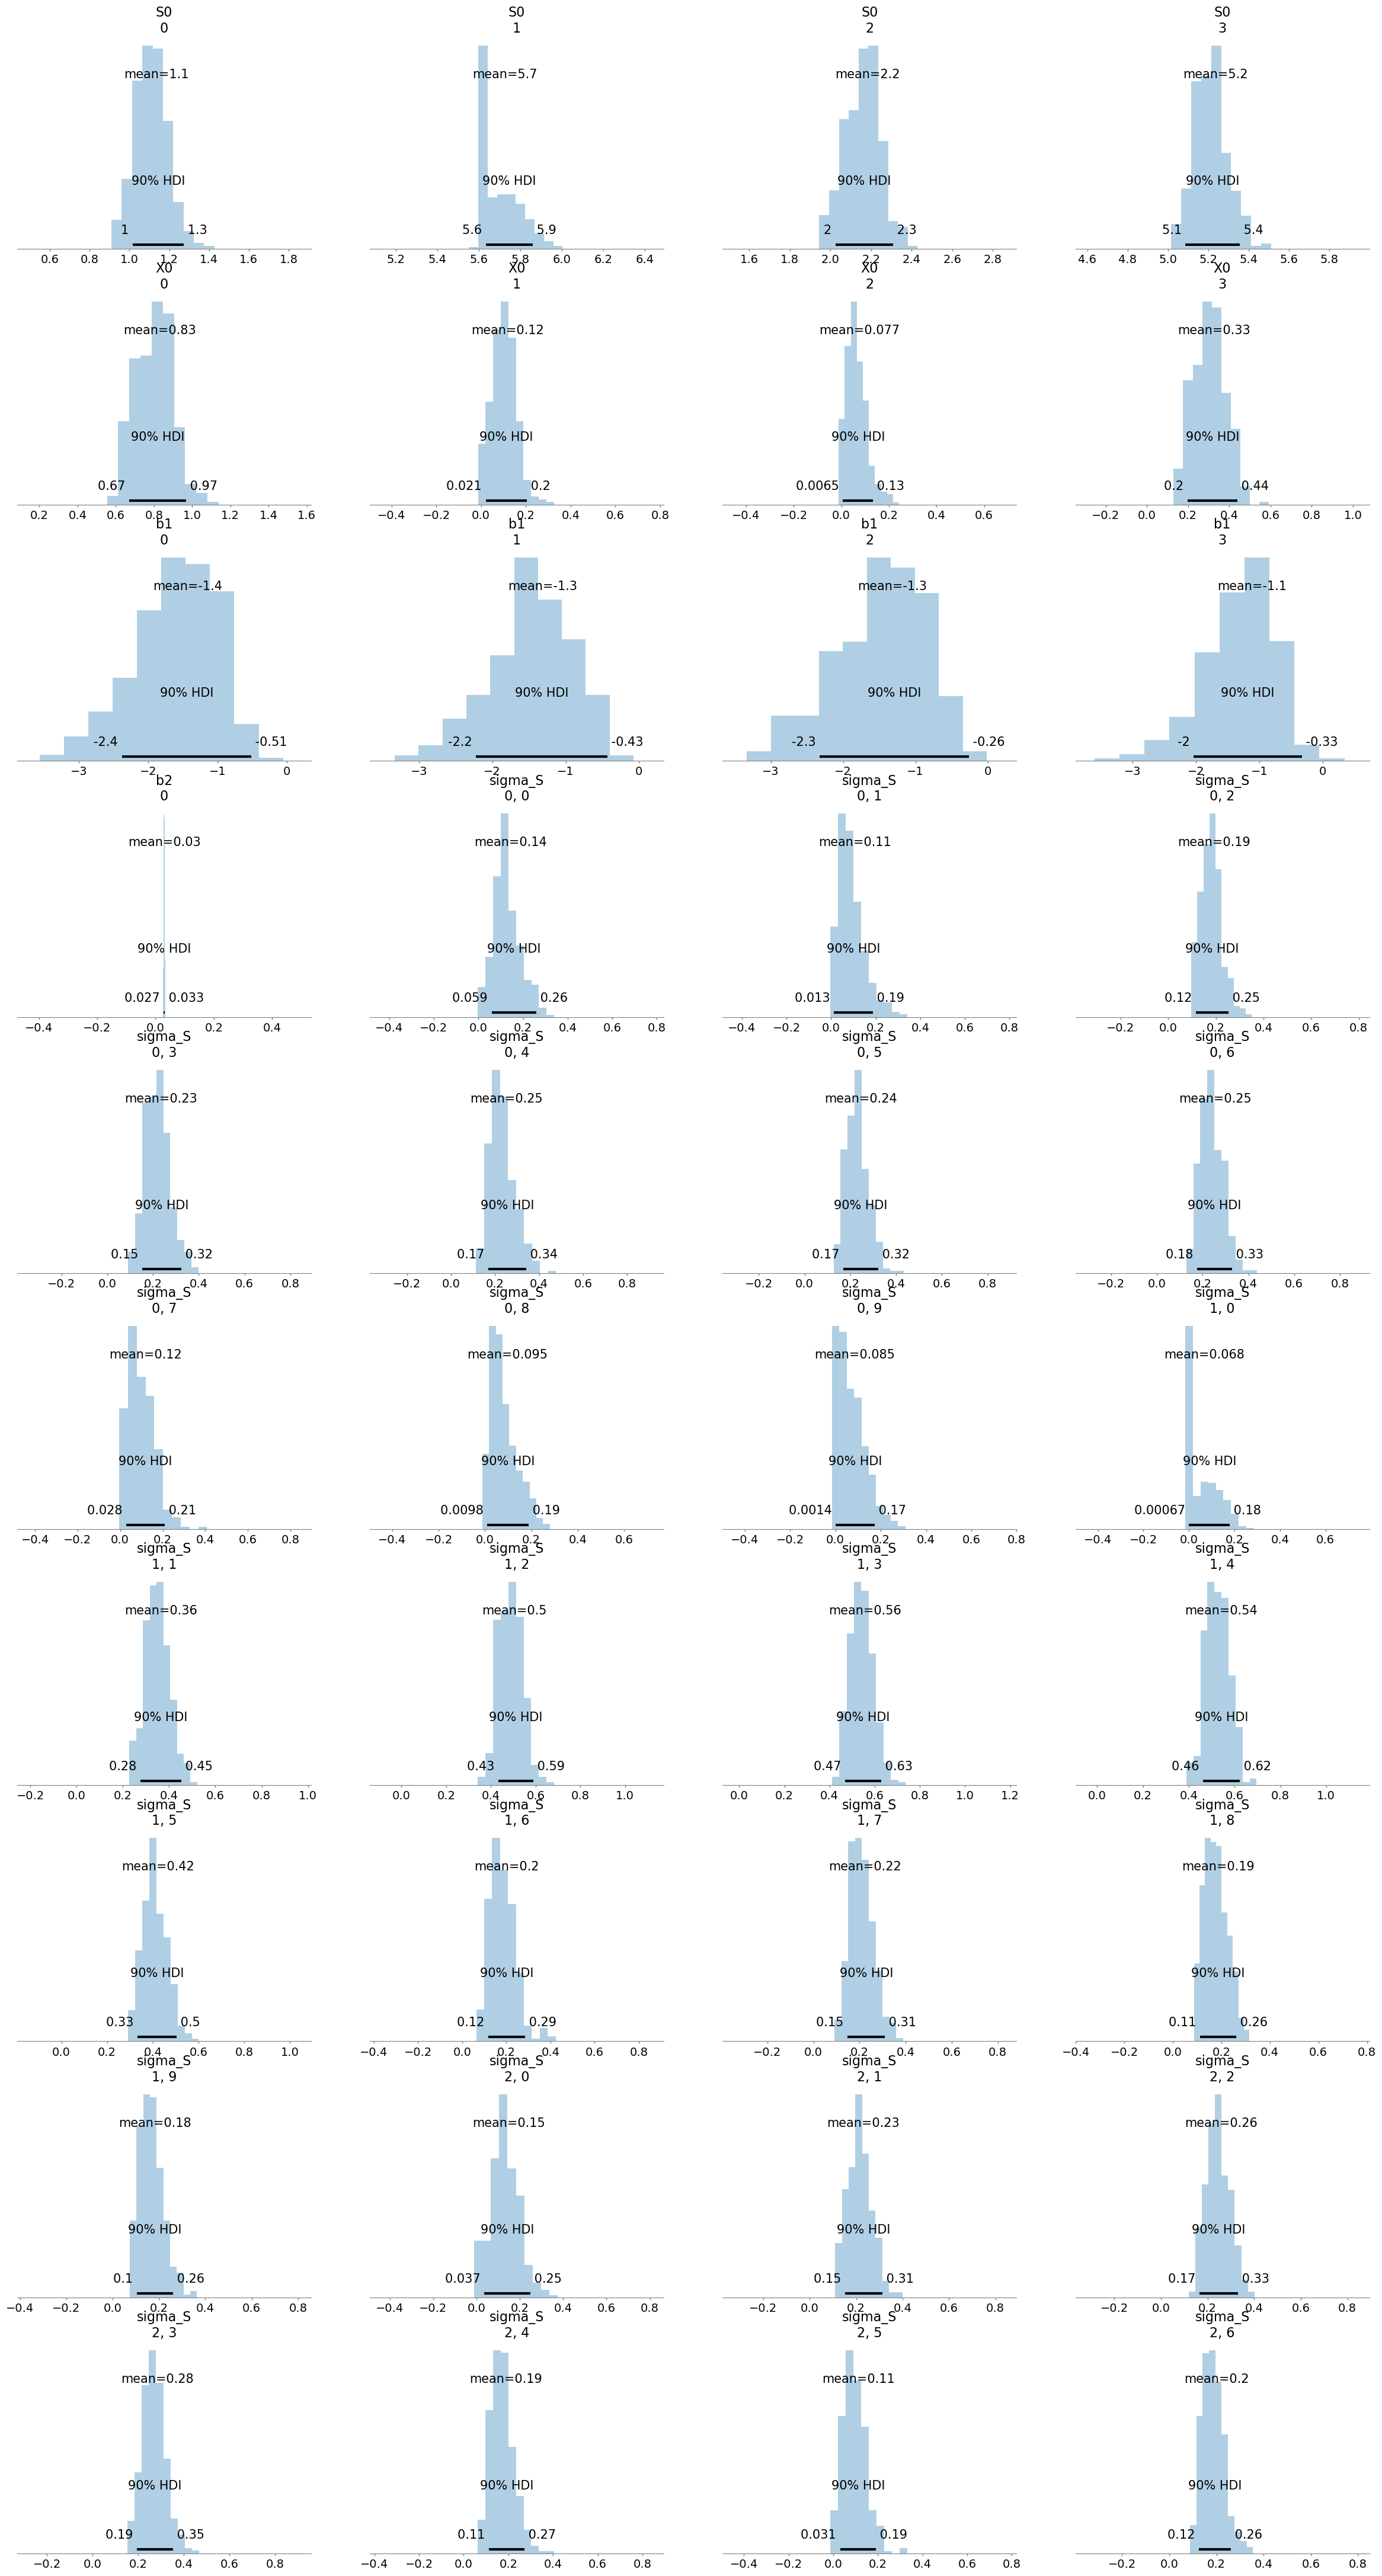

In [17]:
posterior_az = az.from_numpyro(mcmc)
fig_post = az.plot_posterior(
    posterior_az,
    kind="hist",
    backend="matplotlib",
    hdi_prob=0.90,
)


**Visualization**

We can now inspect if our model is over- or underfitting our data by plotting the observed and predicted data over time and in a 1:1 plot. The latter shows a diagonal line for optimal fitting. We can also use standard metrics like the root mean square error (RMSE) and $R^2$ to evaluate our model. In the observed vs predicted plot, a straight diagonal line shows the theoretical optimal fitting of our data.

In [18]:
pred_S = posterior_predictive["obs_S"]
pred_X = posterior_predictive["obs_X"]

In [19]:
quantiles=jnp.array([10.0, 90.0])
mu_S = jnp.mean(pred_S, 0)
pi_S = jnp.percentile(pred_S, quantiles, 0)

mu_X = jnp.mean(pred_X, 0)
pi_X = jnp.percentile(pred_X, quantiles, 0)

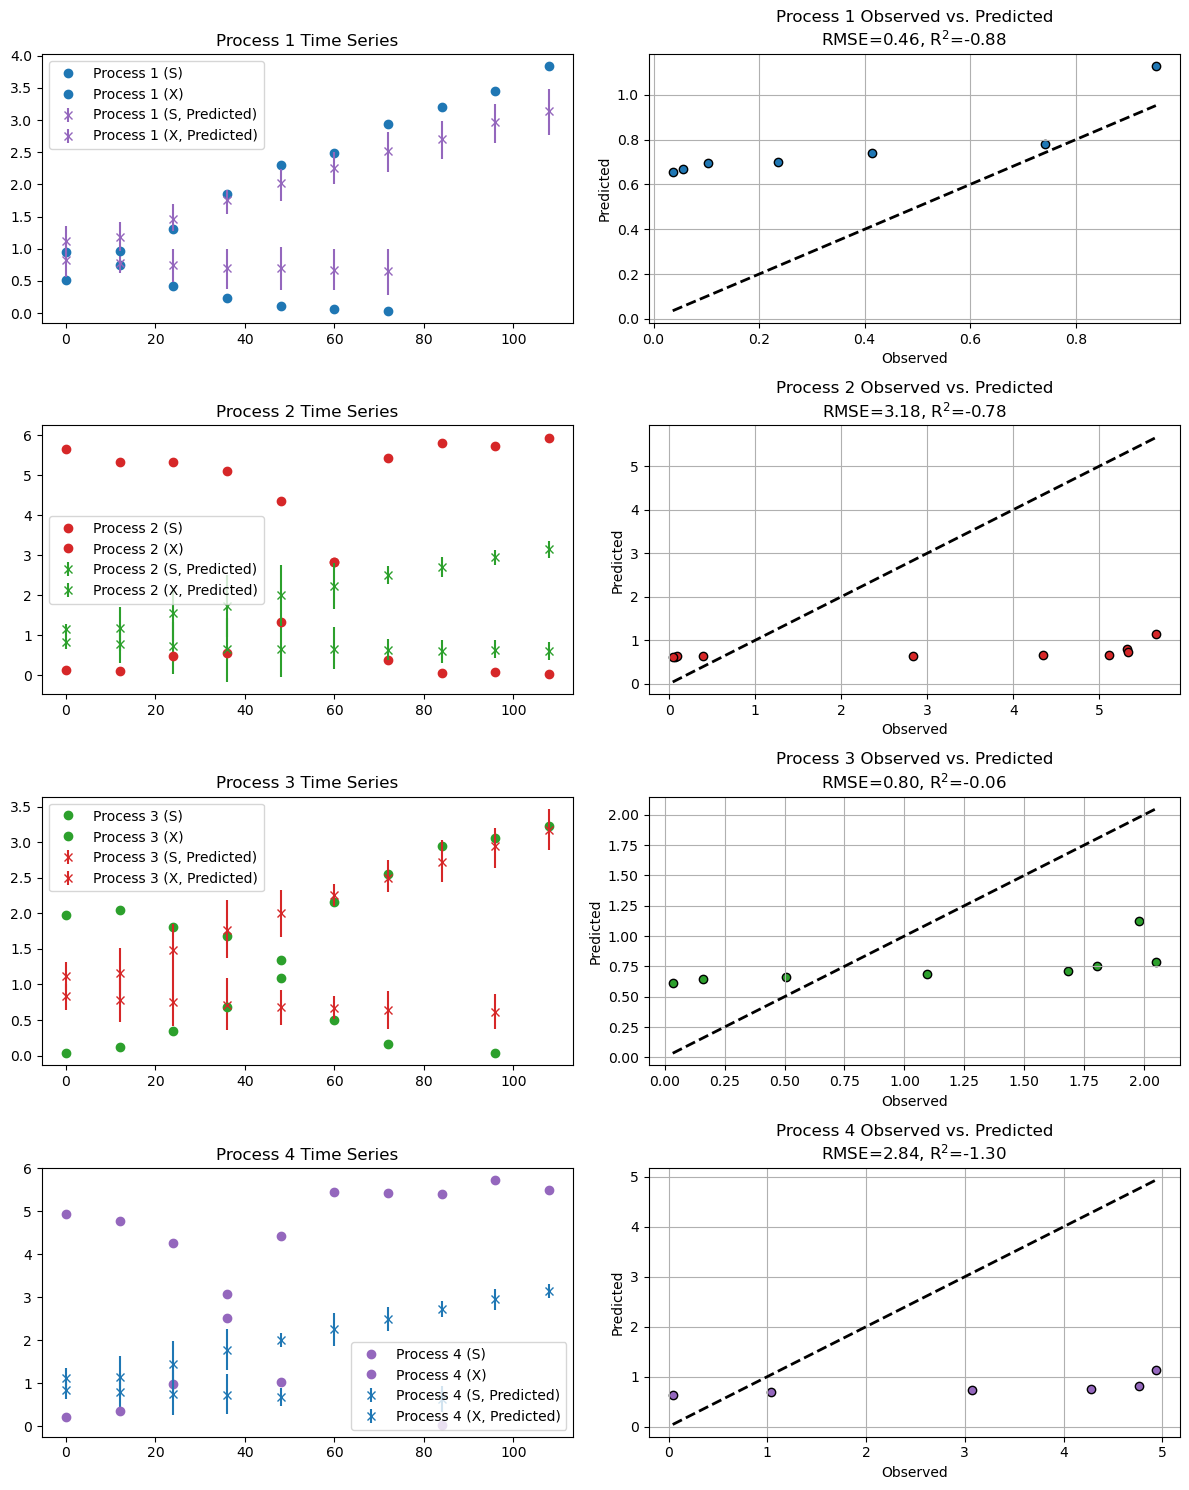

In [20]:
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple']
states = ['Process 1', 'Process 2', 'Process 3', 'Process 4']

# Create subplots for time series data and observed vs. predicted data
fig, axs = plt.subplots(4, 2, figsize=(12, 15)) # 4 rows, 2 columns

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Plot time series and observed vs. predicted for each state variable
for i, (state, color, color2, obs_S, pred_S, quantile_low_S, quantile_high_S, 
        obs_X, pred_X, quantile_low_X, quantile_high_X) in enumerate(zip(states, colors, colors[::-1], all_S, mu_S, pi_S[0], pi_S[1], all_X, mu_X, pi_X[0], pi_X[1])):
    
    obs_S = np.array(obs_S)
    obs_X = np.array(obs_X)
    pred_S = np.array(pred_S)
    pred_X = np.array(pred_X)
    
    # Mask NaN values
    mask_S = np.isnan(obs_S)
    observations_filtered_S = obs_S[~mask_S]
    predictions_filtered_S = pred_S[~mask_S]
    
    mask_X = np.isnan(obs_X)
    observations_filtered_X = obs_X[~mask_X]
    predictions_filtered_X = pred_X[~mask_X]
    
    # Assuming pi_S contains quantiles, extract them and apply same masking
    lower_bound_S = quantile_low_S[~mask_S]
    upper_bound_S = quantile_high_S[~mask_S]
    
    lower_bound_X = quantile_low_X[~mask_X]
    upper_bound_X = quantile_high_X[~mask_X]
    
    # Calculate the error margins
    lower_error_S = predictions_filtered_S - lower_bound_S
    upper_error_S = upper_bound_S - predictions_filtered_S
    
    lower_error_X = predictions_filtered_X - lower_bound_X
    upper_error_X = upper_bound_X - predictions_filtered_X
    
    # Make sure no negative values in yerr
    lower_error_S = np.abs(lower_error_S)
    upper_error_S = np.abs(upper_error_S)
    
    lower_error_X = np.abs(lower_error_X)
    upper_error_X = np.abs(upper_error_X)
    
    t_filtered_S = all_times[i][~mask_S]
    t_filtered_X = all_times[i][~mask_X]

    # Time series plot for S
    axs[2*i].plot(t_filtered_S, observations_filtered_S, "o", label=f'{state} (S)', color=color)
    axs[2*i].errorbar(t_filtered_S, predictions_filtered_S, yerr=[lower_error_S, upper_error_S], fmt='x', label=f'{state} (S, Predicted)', color=color2)
    axs[2*i].set_title(f'{state} Time Series')
    axs[2*i].legend()
    
    # Time series plot for X
    axs[2*i].plot(t_filtered_X, observations_filtered_X, "o", label=f'{state} (X)', color=color)
    axs[2*i].errorbar(t_filtered_X, predictions_filtered_X, yerr=[lower_error_X, upper_error_X], fmt='x', label=f'{state} (X, Predicted)', color=color2)
    axs[2*i].set_title(f'{state} Time Series')
    axs[2*i].legend()

    # Calculate RMSE and R^2
    rmse_S = root_mean_squared_error(observations_filtered_S, predictions_filtered_S)
    r2_S = r2_score(observations_filtered_S, predictions_filtered_S)
    
    # Observed vs. Predicted plot with RMSE and R^2 in the title
    axs[2*i+1].scatter(observations_filtered_S, predictions_filtered_S, color=color, edgecolors='k')
    axs[2*i+1].plot([observations_filtered_S.min(), observations_filtered_S.max()], [observations_filtered_S.min(), observations_filtered_S.max()], 'k--', lw=2)
    axs[2*i+1].set_title(f'{state} Observed vs. Predicted\nRMSE={rmse_S:.2f}, R$^2$={r2_S:.2f}')
    axs[2*i+1].set_xlabel('Observed')
    axs[2*i+1].set_ylabel('Predicted')
    axs[2*i+1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

**Predicting on unseen data**

We can now sample values for the hyperparameters from our posterior distribution and use them to predict values. We can now also use our metrics like RMSE and $R^2$ to evaluate the performance.

In [50]:
# Plot for new test process
# Number of posterior samples to use for prediction
num_samples = 1000
indices = jnp.arange(len(posterior_samples['w1']))

# For reproducibility, set a random seed
rng_key = jax.random.PRNGKey(3)
sampled_indices = jax.random.choice(rng_key, indices, (num_samples,))

predictions = []
for idx in sampled_indices:
    # Get one sample from the posterior
    w1_sample = posterior_samples['w1'][idx]
    b1_sample = posterior_samples['b1'][idx]
    w2_sample = posterior_samples['w2'][idx]
    b2_sample = posterior_samples['b2'][idx]
    
    theta_sample = (w1_sample, b1_sample, w2_sample, b2_sample)
    
    # Run the prediction with the sampled parameters
    prediction_sample = solve_reaction_with_feeding(all_times_test[0], all_S0_test[0], all_X0_test[0], theta_sample, all_feed_times_test[0], 
                                                    all_feed_volumes_test[0], all_feed_concentration_s_test[0], all_start_volumes_test[0])
    predictions.append(prediction_sample)

predictions = jnp.array(predictions)

# Example: If predictions shape is (num_samples, num_components, num_time_points)
mean_prediction = jnp.mean(predictions, axis=0)
lower_credible_interval = jnp.percentile(predictions, 2.5, axis=0)
upper_credible_interval = jnp.percentile(predictions, 97.5, axis=0)

In [52]:
# Transpose arrays
mean_prediction = mean_prediction.T
lower_credible_interval = lower_credible_interval.T
upper_credible_interval = upper_credible_interval.T

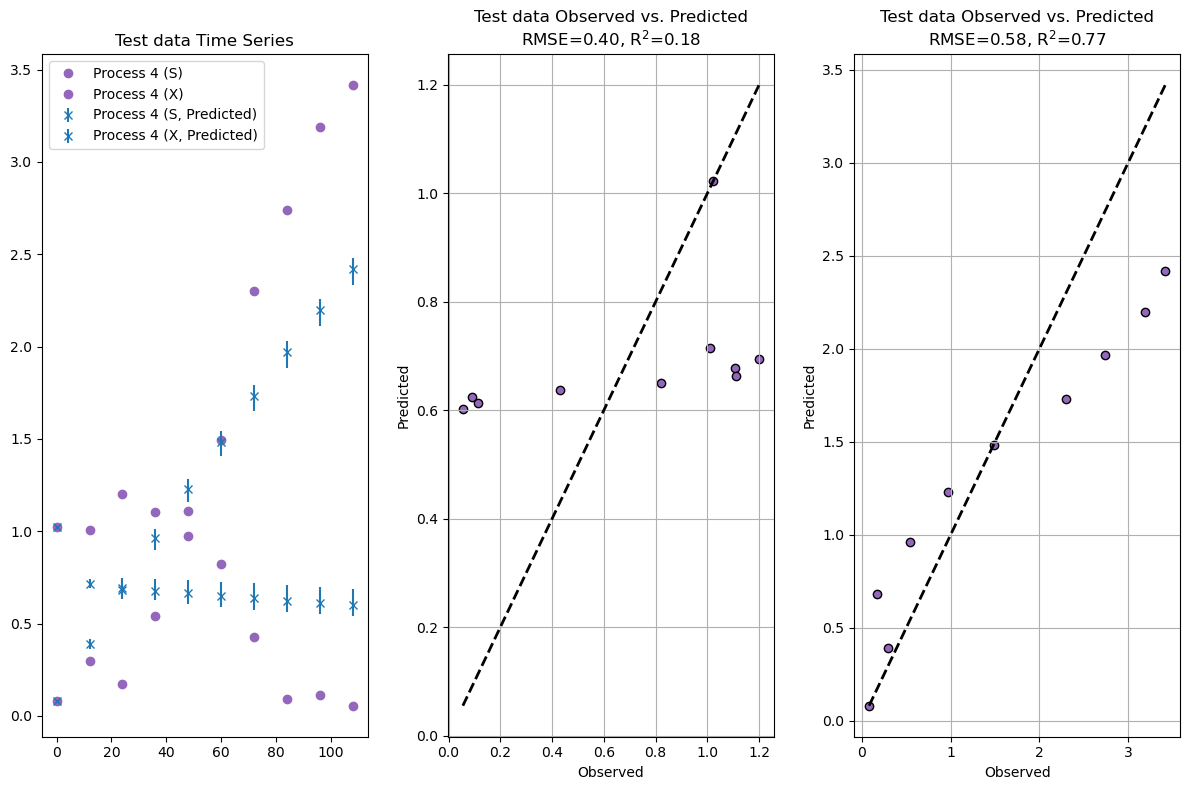

In [65]:
# Show validation plot for test set
fig, axs = plt.subplots(1, 3, figsize=(12, 8)) # 1 row, 2 columns
axs = axs.flatten()


# Calculate the error margins
lower_error_S = np.abs(mean_prediction[0, :] - lower_credible_interval[0, :])
upper_error_S = np.abs(upper_credible_interval[0, :] - mean_prediction[0, :])
lower_error_X = np.abs(mean_prediction[1, :] - lower_credible_interval[1, :])
upper_error_X = np.abs(upper_credible_interval[1, :] - mean_prediction[1, :])

observations_filtered_S = all_S_test.squeeze()
observations_filtered_X = all_X_test.squeeze()

predictions_filtered_S = mean_prediction[0, :]
predictions_filtered_X = mean_prediction[1, :]


# Time series plot for S
axs[0].plot(all_times_test.squeeze(), observations_filtered_S, "o", label=f'{state} (S)', color=color)
axs[0].errorbar(all_times_test.squeeze(), predictions_filtered_S, yerr=[lower_error_S, upper_error_S], fmt='x', label=f'{state} (S, Predicted)', color=color2)
axs[0].legend()

# Time series plot for X
axs[0].plot(all_times_test.squeeze(), observations_filtered_X, "o", label=f'{state} (X)', color=color)
axs[0].errorbar(all_times_test.squeeze(), predictions_filtered_X, yerr=[lower_error_X, upper_error_X], fmt='x', label=f'{state} (X, Predicted)', color=color2)
axs[0].set_title(f'Test data Time Series')
axs[0].legend()


# Calculate RMSE and R^2
rmse_S = root_mean_squared_error(observations_filtered_S, predictions_filtered_S)
r2_S = r2_score(observations_filtered_S, predictions_filtered_S)

rmse_X = root_mean_squared_error(observations_filtered_X, predictions_filtered_X)
r2_X = r2_score(observations_filtered_X, predictions_filtered_X)

# Observed vs. Predicted plot with RMSE and R^2 in the title
axs[1].scatter(observations_filtered_S, predictions_filtered_S, color=color, edgecolors='k')
axs[1].plot([observations_filtered_S.min(), observations_filtered_S.max()], [observations_filtered_S.min(), observations_filtered_S.max()], 'k--', lw=2)
axs[1].set_title(f'Test data Observed vs. Predicted\nRMSE={rmse_S:.2f}, R$^2$={r2_S:.2f}')
axs[1].set_xlabel('Observed')
axs[1].set_ylabel('Predicted')
axs[1].grid(True)

# Observed vs. Predicted plot with RMSE and R^2 in the title
axs[2].scatter(observations_filtered_X, predictions_filtered_X, color=color, edgecolors='k')
axs[2].plot([observations_filtered_X.min(), observations_filtered_X.max()], [observations_filtered_X.min(), observations_filtered_X.max()], 'k--', lw=2)
axs[2].set_title(f'Test data Observed vs. Predicted\nRMSE={rmse_X:.2f}, R$^2$={r2_X:.2f}')
axs[2].set_xlabel('Observed')
axs[2].set_ylabel('Predicted')
axs[2].grid(True)

plt.tight_layout()
plt.show()

## Tuning and Validation:
 - Tune the performance (accuracy on unseen data) of your JAX model using a suitable
method.
 - Explain and visualize the performance metrics that you used.
 - Compare the performance of the tuned model with the untuned model.

### Explain and visualize the performance metrics

For models with multiple parameters, we can use L1 (Lasso) or L2 (Ridge) regularization to prevent overfitting. L1 regularization promotes sparsity by setting some parameters to zero, while L2 regularization reduces the size of all parameters without completely eliminating one. However, in our model, which is an artificial neural network (ANN), we use a dropout layer instead to avoid overfitting and improve generalization. This layer randomly turns off some neurons during training to prevent the network from relying too much on certain neurons, thereby promoting more robust feature learning.

We will use $R^2$ (predicted vs. measured value) and RMSE (root mean square error) to compare the performance of our untuned and tuned model. We could also use mean absolute error (MAE) or mean absolute percentage error (MAPE) which gives better interpretability or normalize the RMSE (NRMSE).

**Note:** Usually, we would just pass the ```train=false``` argument when runing the inference. I forgot to change the code and just copy pasted the code with activating training here. It is also important to deactivate the training behavior after training.

In [66]:
# The raction model
def reaction_model(t: float, concentrations: jnp.array, args: tuple, train: bool=True) -> jnp.array:
    """
    Reaction model to describe the changes in concentrations over time using a neural network.

    Args:
        t (float): Time variable.
        concentrations (array): Current concentrations [S, X].
        args (tuple): Model parameters.
        train (bool): Whether or not the model is in training mode.

    Returns:
        array: Derivatives [dS_dt, dX_dt].
    """

    # Split the concentrations
    S, X = concentrations
    
    # Define variables. Can be extended for further arguments
    theta = args

    # Split theta into weights and biases
    w1, b1, w2, b2 = theta
    
    # Split random key to dropout key and random number generator
    dropout_key, dropout_rng = jax.random.split(jax.random.PRNGKey(0))
    
    # Define dropout rate for the dropout layer during training
    dropout_rate = 0.5
    
    # Apply the ANN with custom dropout
    k_ANN = jax.nn.relu(jnp.dot(S, w1) + b1)
    dropout1_rng, dropout2_rng = jax.random.split(dropout_rng)
    k_ANN = custom_dropout(k_ANN, dropout_rate, dropout1_rng, train=True)

    k_ANN = jnp.dot(k_ANN, w2) + b2

    # Ensure k_ANN is scalar
    k_ANN = jnp.squeeze(k_ANN)

    # Define the actual ODEs
    dS_dt = -k_ANN * S
    dX_dt = k_ANN * S
    
    return jnp.array([dS_dt, dX_dt])

In [67]:
# Inference using MCMC
nuts_kernel_tuned = NUTS(model, dense_mass=True, init_strategy=init_to_median())
mcmc_tuned = MCMC(nuts_kernel_tuned, num_samples=300, num_warmup=300)

mcmc_tuned.run(jax.random.PRNGKey(3), all_times, all_S0, all_X0, all_S, all_X, all_feed_times, 
             all_feed_volumes, all_feed_concentration_s, all_start_volumes)

mcmc_tuned.print_summary()

sample: 100%|██████████| 600/600 [8:05:16<00:00, 48.53s/it, 1023 steps of size 9.43e-03. acc. prob=0.75]    



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       S0[0]      1.11      0.08      1.10      1.00      1.24     83.67      1.01
       S0[1]      5.77      0.08      5.76      5.63      5.87     61.81      1.10
       S0[2]      2.21      0.08      2.21      2.08      2.34    137.29      1.00
       S0[3]      5.25      0.09      5.26      5.08      5.39     99.49      1.02
       X0[0]      0.88      0.08      0.88      0.76      1.03     84.05      1.00
       X0[1]      0.13      0.01      0.13      0.10      0.15     73.62      1.02
       X0[2]      0.04      0.03      0.04      0.01      0.08     41.97      1.02
       X0[3]      0.37      0.08      0.37      0.25      0.50     76.71      1.03
       b1[0]     -1.02      0.54     -0.96     -1.96     -0.27     47.18      1.00
       b1[1]     -1.24      0.67     -1.10     -2.31     -0.20     15.83      1.02
       b1[2]     -0.68      0.81     -0.73     -2.07      0.57     64.09      1.02
   

In [68]:
# The raction model
def reaction_model(t: float, concentrations: jnp.array, args: tuple, train: bool=True) -> jnp.array:
    """
    Reaction model to describe the changes in concentrations over time using a neural network.

    Args:
        t (float): Time variable.
        concentrations (array): Current concentrations [S, X].
        args (tuple): Model parameters.
        train (bool): Whether or not the model is in training mode.

    Returns:
        array: Derivatives [dS_dt, dX_dt].
    """

    # Split the concentrations
    S, X = concentrations
    
    # Define variables. Can be extended for further arguments
    theta = args

    # Split theta into weights and biases
    w1, b1, w2, b2 = theta
    
    # Split random key to dropout key and random number generator
    dropout_key, dropout_rng = jax.random.split(jax.random.PRNGKey(0))
    
    # Define dropout rate for the dropout layer during training
    dropout_rate = 0.5
    
    # Apply the ANN with custom dropout
    k_ANN = jax.nn.relu(jnp.dot(S, w1) + b1)
    dropout1_rng, dropout2_rng = jax.random.split(dropout_rng)
    k_ANN = custom_dropout(k_ANN, dropout_rate, dropout1_rng, train=False)

    k_ANN = jnp.dot(k_ANN, w2) + b2

    # Ensure k_ANN is scalar
    k_ANN = jnp.squeeze(k_ANN)

    # Define the actual ODEs
    dS_dt = -k_ANN * S
    dX_dt = k_ANN * S
    
    return jnp.array([dS_dt, dX_dt])

In [69]:
# Plot for new test process with tuned process
# Number of posterior samples to use for prediction
posterior_samples = mcmc_tuned.get_samples()
num_samples = 1000
indices = jnp.arange(len(posterior_samples['w1']))

# For reproducibility, set a random seed
rng_key = jax.random.PRNGKey(4)
sampled_indices = jax.random.choice(rng_key, indices, (num_samples,))

predictions = []
for idx in sampled_indices:
    # Get one sample from the posterior
    w1_sample = posterior_samples['w1'][idx]
    b1_sample = posterior_samples['b1'][idx]
    w2_sample = posterior_samples['w2'][idx]
    b2_sample = posterior_samples['b2'][idx]
    
    theta_sample = (w1_sample, b1_sample, w2_sample, b2_sample)
    
    # Run the prediction with the sampled parameters
    prediction_sample = solve_reaction_with_feeding(all_times_test[0], all_S0_test[0], all_X0_test[0], theta_sample, all_feed_times_test[0], 
                                                    all_feed_volumes_test[0], all_feed_concentration_s_test[0], all_start_volumes_test[0])
    predictions.append(prediction_sample)

predictions = jnp.array(predictions)

# Example: If predictions shape is (num_samples, num_components, num_time_points)
mean_prediction = jnp.mean(predictions, axis=0)
lower_credible_interval = jnp.percentile(predictions, 2.5, axis=0)
upper_credible_interval = jnp.percentile(predictions, 97.5, axis=0)

In [70]:
# Transpose arrays
mean_prediction = mean_prediction.T
lower_credible_interval = lower_credible_interval.T
upper_credible_interval = upper_credible_interval.T

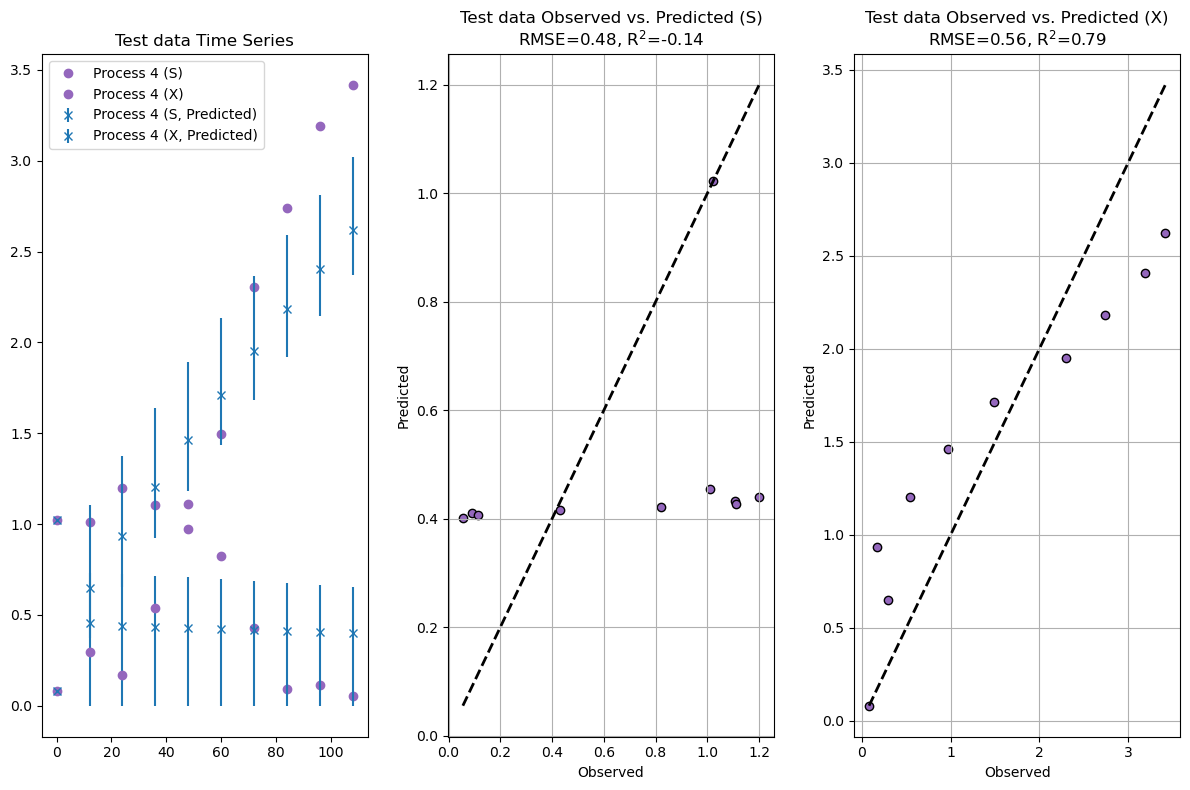

In [72]:
# Show validation plot for test set
fig, axs = plt.subplots(1, 3, figsize=(12, 8)) # 1 row, 2 columns
axs = axs.flatten()


# Calculate the error margins
lower_error_S = np.abs(mean_prediction[0, :] - lower_credible_interval[0, :])
upper_error_S = np.abs(upper_credible_interval[0, :] - mean_prediction[0, :])
lower_error_X = np.abs(mean_prediction[1, :] - lower_credible_interval[1, :])
upper_error_X = np.abs(upper_credible_interval[1, :] - mean_prediction[1, :])

observations_filtered_S = all_S_test.squeeze()
observations_filtered_X = all_X_test.squeeze()

predictions_filtered_S = mean_prediction[0, :]
predictions_filtered_X = mean_prediction[1, :]


# Time series plot for S
axs[0].plot(all_times_test.squeeze(), observations_filtered_S, "o", label=f'{state} (S)', color=color)
axs[0].errorbar(all_times_test.squeeze(), predictions_filtered_S, yerr=[lower_error_S, upper_error_S], fmt='x', label=f'{state} (S, Predicted)', color=color2)
axs[0].legend()

# Time series plot for X
axs[0].plot(all_times_test.squeeze(), observations_filtered_X, "o", label=f'{state} (X)', color=color)
axs[0].errorbar(all_times_test.squeeze(), predictions_filtered_X, yerr=[lower_error_X, upper_error_X], fmt='x', label=f'{state} (X, Predicted)', color=color2)
axs[0].set_title(f'Test data Time Series')
axs[0].legend()


# Calculate RMSE and R^2
rmse_S = root_mean_squared_error(observations_filtered_S, predictions_filtered_S)
r2_S = r2_score(observations_filtered_S, predictions_filtered_S)

rmse_X = root_mean_squared_error(observations_filtered_X, predictions_filtered_X)
r2_X = r2_score(observations_filtered_X, predictions_filtered_X)

# Observed vs. Predicted plot with RMSE and R^2 in the title
axs[1].scatter(observations_filtered_S, predictions_filtered_S, color=color, edgecolors='k')
axs[1].plot([observations_filtered_S.min(), observations_filtered_S.max()], [observations_filtered_S.min(), observations_filtered_S.max()], 'k--', lw=2)
axs[1].set_title(f'Test data Observed vs. Predicted (S)\nRMSE={rmse_S:.2f}, R$^2$={r2_S:.2f}')
axs[1].set_xlabel('Observed')
axs[1].set_ylabel('Predicted')
axs[1].grid(True)

# Observed vs. Predicted plot with RMSE and R^2 in the title
axs[2].scatter(observations_filtered_X, predictions_filtered_X, color=color, edgecolors='k')
axs[2].plot([observations_filtered_X.min(), observations_filtered_X.max()], [observations_filtered_X.min(), observations_filtered_X.max()], 'k--', lw=2)
axs[2].set_title(f'Test data Observed vs. Predicted (X)\nRMSE={rmse_X:.2f}, R$^2$={r2_X:.2f}')
axs[2].set_xlabel('Observed')
axs[2].set_ylabel('Predicted')
axs[2].grid(True)

plt.tight_layout()
plt.show()

## Model Analysis
 - Explain the behavior and characteristics of your model.


The behavior of our model is determined by the chemical reaction $1S$ -> $1X$. However, the exact kinetics are unknown. However, from the reaction we can deduce that the reaction depends on the concentration of $S$ and should be controlled by a rate parameter $k$. The actual kinetics behind $k$ is unknown (probably nonlinear), so we replace it with a simple shallow NN whose parameters we estimate with MCMC. We plug everything into an ODE. This way we can easily account for mass balances, e.g. feeding events where we update the concentrations and volume after feeding. In general, this model also generalizes better than a purely data-driven model and could account for more mass balances (evaporation, volume change due to sampling, etc.).

Instead of treating $k$ as a constant, our model uses a simple ANN with a hidden layer to dynamically predict $k$ based on the concentrations of $S$. If we want to consider inhibition effects on $k$ as a function of the concentration of $X$, we can extend our input to include $X$ concentrations. In this way, the model can capture more complex relationships between the concentrations and the rate parameter, which could reflect more realistic scenarios in chemical processes.

The parameters of the neural network are derived by Bayesian inference using Markov Chain Monte Carlo (MCMC) methods (in particular with the NUTS sampler in NumPyro). This modeling approach provides not only point estimates of the parameters, but also a quantification of the uncertainty in the predictions. The confidence intervals (95% CI) give an impression of the confidence in the model's predictions. We used the posterior samples from MCMC to make predictions for unknown data using the predictive class of NumPyro. This allows us to predict future concentrations under new conditions and quantify the associated uncertainty, which is crucial in scientific and engineering applications.

 - Explain and justify the method(s) that you chose for your analysis – what alternatives did you consider?

This type of hybrid model (combining a data-driven model part like ANN with a mechanistic model) is known for its good predictive capabilities beyond the training data. It includes mass balances to account for changes due to feed and sampling, even if the actual kinetics of extraction are unknown. Its rather simple structure (shallow depth and few nodes) is good enough to capture the slight nonlinearity in the data and to account for the small amount of training data. With the mass balance, we could easily adjust the feeding or sampling events in our model to make further predictions.

An alternative approach would be to model the concentration changes using Gaussian processes (GP), e.g. with gpjax. They work well for small data sets and also provide mean and uncertainty. Given the equidistant time intervals, we could use them to predict the concentrations at $t_{n+1}$ based on the concentrations at $t_n$ and the feeding rate. However, they would only allow discrete predictions for the respective time intervals. Another approach would be to train an ANN completely on the data. However, this would be limited to the narrow training space. Especially in bioprocesses, for e.g. the pharma industry where this is a critical step, this may not be well justified. 

# Concluding remarks

We see from plotting our training data, that our model is underfitting the data. This might be probably due to the low number of warmup and sampling. Increasing this number could help us archieve better convergence. Also, it might be advisable to change the priors of our weighting matrix to also allow negative values and consider the amount of $X$ in the ANN to consider e.g. exponential growth.